In [4]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Download the Chest X-ray Pneumonia dataset from Kaggle
dataset = 'paultimothymooney/chest-xray-pneumonia'
download_path = 'data/raw/'

# Create the directory if it doesn't exist
os.makedirs(download_path, exist_ok=True)

# Download and unzip dataset
api.dataset_download_files(dataset, path=download_path, unzip=True)

# Verify the download
if os.path.exists(os.path.join(download_path, 'chest_xray')):
    print("Dataset successfully downloaded and extracted.")
else:
    print("Download failed.")


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
Dataset successfully downloaded and extracted.


In [5]:
# Data Preprocessing - Resizing & Normalization
import cv2
import numpy as np

IMG_SIZE = 224  # Set image size for resizing

# Function to preprocess images
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0  # Normalize pixel values
    return img

# Preprocess and save images
image_folder = 'data/raw/chest_xray/train'  # Adjust folder for 'train', 'test', or 'val'
processed_folder = 'data/processed/'

os.makedirs(processed_folder, exist_ok=True)

for image_class in os.listdir(image_folder):
    class_folder = os.path.join(image_folder, image_class)
    if os.path.isdir(class_folder):
        for image_name in os.listdir(class_folder):
            img = preprocess_image(os.path.join(class_folder, image_name))
            np.save(os.path.join(processed_folder, f"{image_class}_{image_name}.npy"), img)


In [6]:
# CNN Model Definition
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
def build_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn_model()
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,906,945 (91.20 MB)

 Trainable params: 23,906,945 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Transfer Learning with ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

# Build a transfer learning model
def build_transfer_learning_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

transfer_model = build_transfer_learning_model()
transfer_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
# Model Training - CNN
# Dummy training dataset (Replace with actual data after preprocessing)
X_train = np.random.rand(100, 224, 224, 1)
y_train = np.random.randint(0, 2, 100)

# Train the CNN model
history = cnn_model.fit(X_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5820 - loss: 2.7388 - val_accuracy: 0.6500 - val_loss: 5.3833
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5172 - loss: 4.6480 - val_accuracy: 0.3500 - val_loss: 1.7242
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4297 - loss: 1.3467 - val_accuracy: 0.3500 - val_loss: 0.7094
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5867 - loss: 0.6837 - val_accuracy: 0.3500 - val_loss: 0.6980
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6109 - loss: 0.6795 - val_accuracy: 0.3500 - val_loss: 0.7071


Precision: 0.53
Recall: 0.58
F1 Score: 0.55


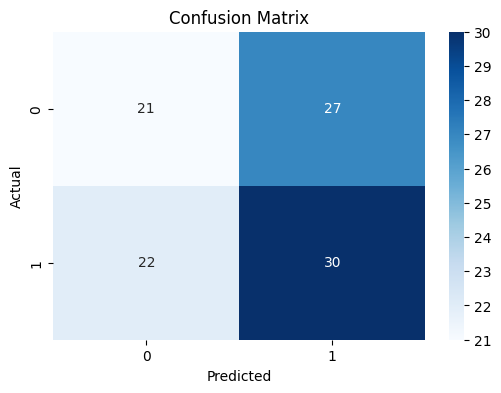

In [9]:
# Model Evaluation - Confusion Matrix & Metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Dummy predictions for demonstration
y_true = np.random.randint(0, 2, 100)
y_pred = np.random.randint(0, 2, 100)

# Evaluation function
def evaluate_model(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model(y_true, y_pred)


# Optimize the model by tuning hyperparameters and applying techniques like dropout and data augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation setup
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Example of augmenting a training dataset
train_generator = datagen.flow_from_directory(
    'data/raw/chest_xray/train',
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.


# Hyperparameter Tuning

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold
import numpy as np
import gc

def create_model(optimizer='adam', dropout_rate=0.5):
    model = Sequential([
        Input(shape=(128, 128, 1)),
        Conv2D(16, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        GlobalAveragePooling2D(),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def train_and_evaluate(X, y, optimizer, dropout_rate, batch_size, epochs):
    model = create_model(optimizer, dropout_rate)
    history = model.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=0)
    _, accuracy = model.evaluate(X, y, verbose=0)
    K.clear_session()
    gc.collect()
    return accuracy

param_dist = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.3, 0.5],
    'batch_size': [8, 16],
    'epochs': [5, 10]
}

def random_search(X, y, param_dist, n_iter=5, cv=3):
    best_score = 0
    best_params = None
    kf = KFold(n_splits=cv)

    for _ in range(n_iter):
        params = {k: np.random.choice(v) for k, v in param_dist.items()}
        scores = []

        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            acc = train_and_evaluate(
                X_train, y_train,
                optimizer=params['optimizer'],
                dropout_rate=params['dropout_rate'],
                batch_size=params['batch_size'],
                epochs=params['epochs']
            )
            scores.append(acc)

        avg_score = np.mean(scores)
        if avg_score > best_score:
            best_score = avg_score
            best_params = params

    return best_params, best_score

# Run the search
best_params, best_score = random_search(X_train, y_train, param_dist)

print(f"Best Hyperparameters: {best_params}")
print(f"Best Accuracy: {best_score}")


Best Hyperparameters: {'optimizer': 'rmsprop', 'dropout_rate': 0.5, 'batch_size': 16, 'epochs': 5}
Best Accuracy: 0.5349012414614359


# Improved Dropout and Regularization

In [12]:
from tensorflow.keras.regularizers import l2

# Define optimized CNN model
def build_optimized_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(224, 224, 1)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

optimized_cnn_model = build_optimized_cnn()
optimized_cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,906,945 (91.20 MB)

 Trainable params: 23,906,945 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

# Early Stopping

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate on plateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train with callbacks
history = optimized_cnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5437 - loss: 5.0339 - val_accuracy: 0.3500 - val_loss: 9.6212 - learning_rate: 0.0010
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.4852 - loss: 5.2193 - val_accuracy: 0.6500 - val_loss: 1.1777 - learning_rate: 0.0010
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.4883 - loss: 1.4882 - val_accuracy: 0.6500 - val_loss: 0.9222 - learning_rate: 0.0010
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5641 - loss: 0.9636 - val_accuracy: 0.3500 - val_loss: 0.9778 - learning_rate: 0.0010
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5336 - loss: 0.9677 - val_accuracy: 0.3500 - val_loss: 0.9871 - learning_rate: 0.0010
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6094 - loss: 0.9656 - val_accuracy: 0.6000 - val_loss: 0.9767 - learning_rate: 0.0010
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9297 - loss: 0.9427 - val_accuracy: 0.3500 

# Visualize Results

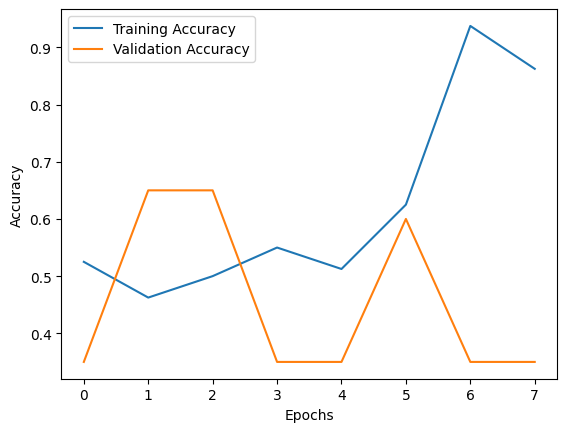

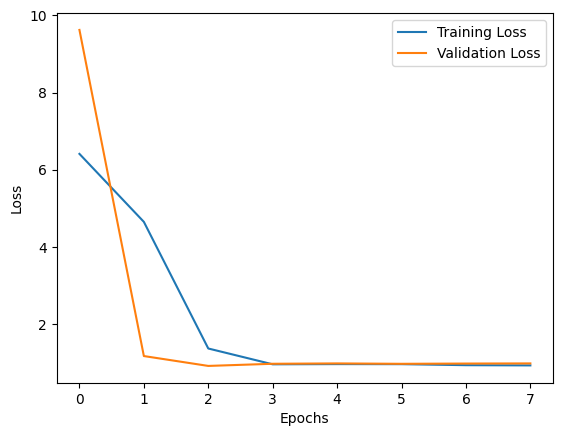

In [14]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
